# 数据规整：连接、联合与重塑

在很多应用中，数据可能分布在多个文件或数据库中，抑或以某种不易于分析的格式进行排列。本章关注于对`数据联合`、`连接`以及`重排列`有用的工具。

首先，要介绍pandas中的分层索引概念，它广泛用于以上操作。然后，深入介绍一些特殊的数据操作。在第14章，你可以看到这些工具的多种应用。

## 分层索引

分层索引（hierarchical indexing）是pandas的一项重要功能，它使你能在一个轴上拥有多个（两个以上）索引级别。抽象点说，它使你能以低维度形式处理高维度数据。我们先来看一个简单的例子：创建一个Series，并用一个由列表或数组组成的列表作为索引：

In [3]:
import numpy as np
import pandas as pd

In [4]:
data = pd.Series(np.random.randn(9),
                index=[list('aaabbccdd'),[1,2,3,1,3,1,2,2,3]])
data

a  1   -0.870964
   2   -0.376682
   3   -0.338312
b  1   -1.310756
   3    0.055547
c  1    0.861381
   2    0.926371
d  2    0.755189
   3   -0.678427
dtype: float64

看到的结果是经过美化的带有MultiIndex索引的Series的美化视图。索引之间的“间隔”表示“直接使用上面的标签”：

In [5]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

>levels是真正的轴标签，labels是每个数据在levels中相对应的具体位置

对于一个分层索引的对象，可以使用部分索引，使用部分索引可以间接地选取数据子集：

In [6]:
data['b']

1   -1.310756
3    0.055547
dtype: float64

In [7]:
data['b':'c']

b  1   -1.310756
   3    0.055547
c  1    0.861381
   2    0.926371
dtype: float64

In [8]:
data.loc[['b','d']]

b  1   -1.310756
   3    0.055547
d  2    0.755189
   3   -0.678427
dtype: float64

也可以从“内部”层级进行数据选取：

In [9]:
data.loc[:,2]

a   -0.376682
c    0.926371
d    0.755189
dtype: float64

>只选取“内层”轴标签为2的数据

分层索引在数据重塑和基于分组的操作（如透视表生成）中扮演着重要的角色。例如，可以通过unstack方法将数据重新安排到一个DataFrame中：

In [10]:
data.unstack()
# data.unstack(level=-1, fill_value=None)

,1,2,3
a,-0.870964,-0.376682,-0.338312
b,-1.310756,NaN,0.055547
c,0.861381,0.926371,NaN
d,NaN,0.755189,-0.678427


unstack的反操作是stack：

In [15]:
data.unstack().stack(level=-1)
# a.stack(level=-1, dropna=True)

a  1   -0.870964
   2   -0.376682
   3   -0.338312
b  1   -1.310756
   3    0.055547
c  1    0.861381
   2    0.926371
d  2    0.755189
   3   -0.678427
dtype: float64

>stack和unstack的细节将在本章后续部分进行详细讲解

在DataFrame中，每个轴都可以拥有分层索引：

In [16]:
frame = pd.DataFrame(np.arange(12).reshape((4,3)),
                    index=[list('aabb'),[1,2,1,2]],
                    columns=[['Ohio','Ohio','Colorado'],['Green','Red','Green']])
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

分层的层级可以有名称（可以是字符串或是Python对象）。如果指定了名称，这些名称会在控制台输出中显示：

In [17]:
frame.index.names = ['key1','key2']
frame.columns.names = ['state','color']
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

>注意：小心区分索引名state、color与行标签。

通过部分列索引，可以选出列中的组：

In [18]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

MultiIndex对象可以使用其自身的构造函数创建并复用。前面介绍的带有层级名称的DataFrame的列也可以这样创建：

In [20]:
frame.columns = pd.MultiIndex.from_arrays([['Ohio','Ohio','Colorado'],
                                           ['Green','Red','Green']],
                       names=['state','color'])
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

>效果和上面的一样

**在对含有多层索引的DataFrame进行标签索引时，用类似元组('Ohio','Green')这样的形式来对内层进行索引**

In [22]:
frame.loc[('a',1):('a',2)]

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5

In [23]:
frame.loc[:,[('Ohio','Green')]]

state      Ohio
color     Green
key1 key2      
a    1        0
     2        3
b    1        6
     2        9

### 重排序和层级排序

有时，需要重新调整某条轴上各层级的顺序，或根据指定层级上的值对数据进行排序。swaplevel接受两个级别编号或名称，并返回一个互换了级别的新对象（但数据不会发生变化）

In [21]:
frame.swaplevel('key1','key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

另一方面，sort_index则根据单个级别中的值对数据进行排序。在进行层级交换时，常常也会用到sort_index，以使得最终结果就是按照指定顺序进行字母排序了：

In [92]:
frame.sort_index(level=1)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [93]:
frame.swaplevel(0,1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

>如果索引按字典顺序从最外层开始排序，那么数据选择性能会更好——调用sort_index(levle=0)或soet_index()可以得到这样的结果

还可以用sort_values()对DataFrame的某个列进行排序：

In [24]:
frame.sort_values(by=('Colorado','Green'))

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

### 按层级进行汇总统计

许多对DataFrame和Series的描述和汇总统计都有一个level选项，它用于指定在某条轴上进行聚合操作。以上面那个DataFrame为例，我们可以根据行或列上的层级进行聚合操作：
+ 参数level的取值为不同索引层级的名字，即index.name、columns.name

In [94]:
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [95]:
frame.sum(level='color',axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

上面的例子使用了pandas的groupby机制，这个机制的细节将会在本书后续章节讨论。

### 使用DataFrame的列进行索引

人们经常想要将DataFrame的一个或多个列当做行索引来用，或者可能希望将行索引变成DataFrame的列。以下面这个DataFrame为例：

In [96]:
frame = pd.DataFrame({'a':range(7), 'b':range(7,0,-1), 'c':['one']*3+['two']*4,
                     'd':list('0120123')})
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


DataFrame的set_index函数会将其一个或多个列转换为行索引，并创建一个新的DataFrame：

In [97]:
frame2 = frame.set_index(['c', 'd'])
#frame.set_index(
#    ['keys', 'drop=True', 'append=False', 'inplace=False', 'verify_integrity=False'])
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

+ 默认情况下被设置为索引的列会被删除，但是也可以将它们保留在DataFrame中：

In [98]:
frame.set_index(['c','d'],drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

>利用一个数值的集合和一列，可以创建一个多层索引

另一方面，reset_index是set_indes的反操作，分层索引的索引层级会被移动到列中：

In [99]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


## 联合与合并数据集

可以通过多种方式将包含在pandas对象中的数据联合在一起：
+ pandas.merge可根据一个或多个键将不同DataFrame中的行连接起来。SQL或其他关系型数据库的用户对此应该会比较熟悉，因为它实现的就是数据库的join操作。
+ pandas.concat可以沿着一条轴将多个对象堆叠到一起。
+ 实例方法combine_first可以将重复数据拼接在一起，用一个对象中的值填充另一个对象中的缺失值。

下面将分别对它们进行讲解，并给出一些例子。本书剩余部分的示例中将经常用到它们。

### 数据库风格的DataFrame连接

数据集的合并（merge）或连接（join）运算是通过一个或多个键将行连接起来的。这些运算是关系型数据库（基于SQL）的核心。pandas的merge函数主要用于将各种join操作算法运用在你的数据上。

下面从一个简单的例子开始：

In [100]:
df1 = pd.DataFrame({'key':list('bbacaab'),'data1':range(7)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [101]:
df2 = pd.DataFrame({'key':list('abd'),'data2':range(3)})
df2

,key,data2
0,a,0
1,b,1
2,d,2


这是一种多对一的连接的例子。df1中key列的数据有多个被标记为a和b的行，而df2中key列的每个值则仅对应一行。对这些对象调用merge即可得到：

In [102]:
pd.merge(df1,df2)
#pd.merge(['left', 'right', "how='inner'", 'on=None', 
#         'left_on=None', 'right_on=None', 'left_index=False', 'right_index=False', 
#         'sort=False', "suffixes=('_x', '_y')", 'copy=True', 'indicator=False', 
#         'validate=None'],)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


注意，这里并没有指明要用哪个列进行连接。如果没有指定，merge就会将重叠的列名当做键。不过，最好明确指定一下：

In [103]:
pd.merge(df1,df2,on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


如果每个对象的列名不同，也可以分别进行指定：

In [25]:
df3 = pd.DataFrame({'lkey':list('bbacaab'),'data1':range(7)})
df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [105]:
df4 = pd.DataFrame({'rkey':list('abd'),'data2':range(3)})
df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [106]:
pd.merge(df3,df4,left_on='lkey',right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


可以看到，结果里面c和d以及与之相关的数据消失了。默认情况下，merge做的是“inner join”；结果中的键是交集。其他方式还有"left"、"right"以及"outer"。外连接（outer join）求取的是键的并集，组合了左连接（left join）和右连接（right joim）的效果：

In [107]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


下表是对how选项的总结：

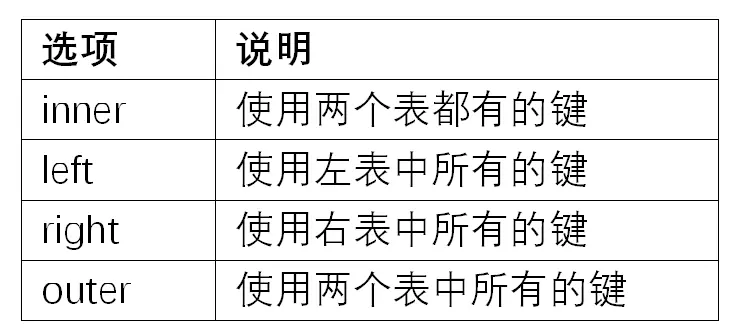

尽管不是很直观，但是多对多的合并有明确的行为。下面是一个例子：

In [26]:
df1 = pd.DataFrame({'key':list('bbacab'),'data1':range(6)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [27]:
df2 = pd.DataFrame({'key':list('ababd'),'data2':range(5)})
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [110]:
pd.merge(df1, df2, on='key',how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


多对多连接产生的是行的笛卡尔积。由于左边的DataFrame有3个"b"行，右边的有2个，所以最终结果中就有6个"b"行。**连接方式只影响出现在结果中的不同的键的值：**

In [111]:
pd.merge(df1,df2,how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


要根据多个键进行合并，传入一个由列名组成的列表即可:

In [28]:
left = pd.DataFrame({'key1':['foo']*2 + ['bar'],
                    'key2':['one','two','one'],
                    'lval':range(1,4)})
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [29]:
right = pd.DataFrame({'key1':['foo']*2 + ['bar']*2,
                     'key2':['one']*3 + ['two'],
                     'rval':range(4,8)})
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [39]:
pd.merge(left,right,on=['key1','key2'],how='outer')
#传入一个由列名组成的列表即可

,key1,key2,lval,rval,_merge
0,foo,one,1.0,4.0,both
1,foo,one,1.0,5.0,both
2,foo,two,2.0,NaN,left_only
3,bar,one,3.0,6.0,both
4,bar,two,NaN,7.0,right_only


结果中会出现哪些键组合取决于所选的合并方式，你可以这样来理解：多个键形成一系列元组，并将其当做单个连接键使用（当然，实际上并不是这么回事）。

>在进行列－列连接时，DataFrame对象中的索引会被丢弃。

合并操作中最后考虑的一个问题是如何处理重叠的列名。虽然可以手动解决重叠问题（参见之前章节中的重命名轴坐标的内容），但是merge有一个suffixes后缀选项，用于在左右两边DataFrame对象的重叠列名后指定需要添加的字符串：

In [115]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [37]:
pd.merge(left,right,on='key1',suffixes=('_left','_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


下表是merge方法的参数参考。使用DataFrame的行索引进行连接是下一节的内容。

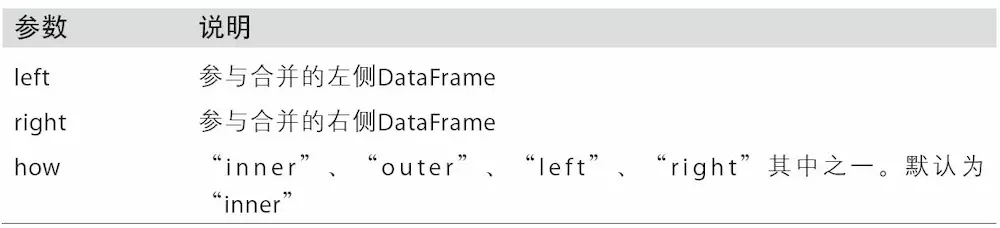

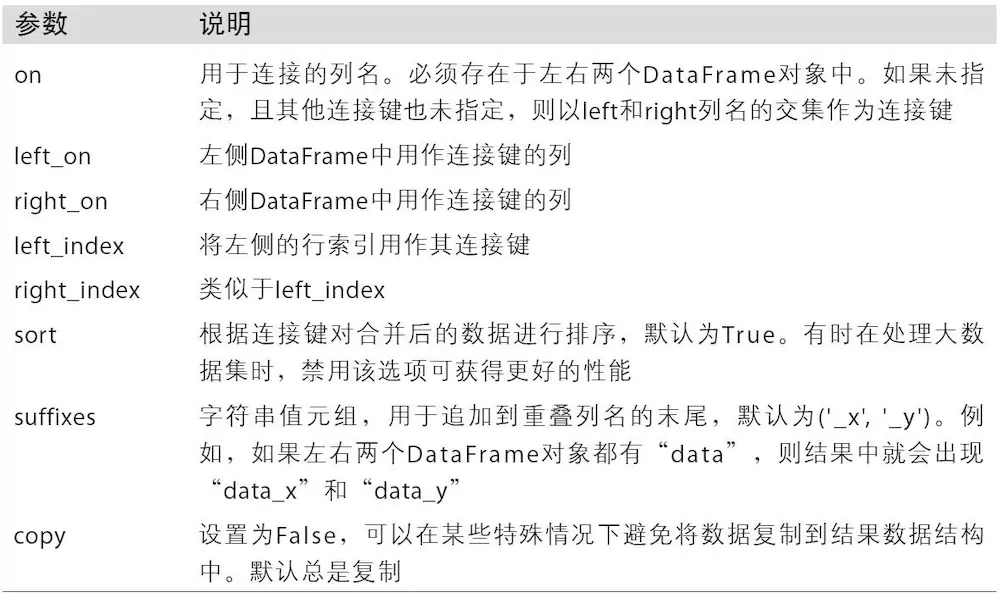

indicator 

    添加特殊的列_merge，它可以指明每个行的来源，根据每行的合并数据的来源，它的值有left_only、right_only或both。

### 根据索引（Index）合并

在某些情况下，DataFrame中用于合并的键是它的索引（index）。在这种情况下，可以传递left_index=True或right_index=True（或者both）来表示索引需要用来作为合并的键：

In [40]:
left1 = pd.DataFrame({'key':list('abaabc'),'value':range(6)})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [41]:
right1 = pd.DataFrame({'group_val':[3.5,7]},index=list('ab'))
right1

,group_val
a,3.5
b,7.0


In [42]:
pd.merge(left1,right1,left_on='key',right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


由于默认的merge方法是求取连接键的交集，因此你可以通过外连接的方式得到它们的并集：

In [120]:
pd.merge(left1,right1,left_on='key', right_index=True,how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


对分层索引的数据，事情就有点复杂了，因为索引的合并默认是多键合并：

In [121]:
lefth = pd.DataFrame({'key1':['Ohio']*3 + ['Nevada']*2,
                     'key2':[2000,2001,2002,2001,2002],
                     'data':np.arange(5.)})
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [122]:
righth = pd.DataFrame(np.arange(12).reshape((6,2)),
                      index=[['Nevada']*2 + ['Ohio']*4,[2001] + [2000]*3 + [2001] + [2002]],
                      columns=['event1','event2'])
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

这种情况下，你必须以列表的形式指明用作合并键的多个列(columns)（注意用how='outer'对重复索引值的处理）：

In [123]:
pd.merge(lefth,righth,left_on=['key1','key2'],right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [124]:
pd.merge(lefth,righth,left_on=['key1','key2'],right_index=True,how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


使用两边的索引（index）进行合并也是可以的：

In [43]:
left2 = pd.DataFrame([[1.,2.],[3.,4.],[5.,6.]],
                    index=list('ace'),
                    columns=['Ohio','Nevada'])
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [44]:
right2 = pd.DataFrame([[7.,8.],[9.,10.],[11.,12.],[13.,14.]],
                     index=list('bcde'),
                     columns=['Missouri','Alabama'])
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [45]:
pd.merge(left2,right2,how='outer',left_index=True,right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame还有一个便捷的join实例方法，它能更为方便地实现按索引合并。**它还可用于合并多个带有相同或相似索引的DataFrame对象，但要求没有重叠的列。**在上面那个例子中，我们可以编写：

In [128]:
left2.join(right2,how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


**因为一些历史版本的遗留原因，DataFrame的join方法默认使用的是左连接(left joimm)，保留左边表的行索引。**   

但它还支持在调用DataFrame的某一列上，连接传递的DataFrame索引：

In [46]:
left1.join(right1,on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


最后，对于简单的索引(index)合并，你还可以向join传入一组DataFrame，下一节会介绍更为通用的concat函数，也能实现此功能：

In [49]:
another = pd.DataFrame([[7.,8.],[9.,10.],[11.,12.],[16.,17.]],
                      index=list('acef'),
                      columns=['New York','Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [50]:
left2.join([right2,another])
# 默认“左连接”

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [132]:
left2.join([right2,another],how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


### 沿轴向连接

另一种数据合并运算也被称作连接（concatenation）、绑定（binding）或堆叠（stacking）。NumPy的concatenation函数可以在NumPy数组上实现该功能：

In [51]:
arr = np.arange(12).reshape((3,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [134]:
np.concatenate([arr,arr],axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

对于pandas对象（如Series和DataFrame），带有标签的轴使你能够进一步推广数组的连接运算。具体点说，你还需要考虑以下这些东西：
+ 如果对象在其它轴上的索引不同，我们应该合并这些轴的不同元素还是只使用交集？
+ 连接的数据集是否需要在结果对象中可识别？
+ 连接轴中保存的数据是否需要保留？许多情况下，DataFrame默认的整数标签最好在连接时删掉。

pandas的concat函数提供了一种一致性的方式解决以上问题。我将给出一些例子来讲解其使用方式。假设有三个没有重叠索引的Series：

>concat默认“外连接”

In [52]:
s1 = pd.Series([0,1],index=list('ab'))
s1

a    0
b    1
dtype: int64

In [53]:
s2 = pd.Series([2,3,4],index=list('cde'))
s2

c    2
d    3
e    4
dtype: int64

In [54]:
s3 = pd.Series([5,6],index=list('fg'))
s3

f    5
g    6
dtype: int64

以列表的格式将对象传递给concat函数，可以将值和索引粘合在一起：
+ Concatenate pandas objects along a particular axis with optional set logic
along the other axes.

In [67]:
pd.concat([s1,s2,s3])
#pd.concat((s1,s2,s3))效果一样
#pd.concat(['objs', 'axis=0', "join='outer'", 'join_axes=None', 
#           'ignore_index=False', 'keys=None', 'levels=None', 'names=None', 
#           'verify_integrity=False', 'sort=None', 'copy=True'])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

默认情况下，concat是沿axis=0的轴向工作的，最终产生一个新的Series。如果传入axis=1，则结果就会变成一个DataFrame（axis=1是列）：

In [139]:
pd.concat([s1,s2,s3],axis=1)

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


在上面的例子种，另一个轴向上没有重叠，从索引的有序并集（外连接）上就可以看出来。传入join='inner'即可得到它们的交集：

In [140]:
s4 = pd.concat([s1,s3])
s4

a    0
b    1
f    5
g    6
dtype: int64

In [141]:
pd.concat([s1,s4],axis=1)

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [142]:
pd.concat([s1,s4],axis=1,join='inner')

,0,1
a,0,0
b,1,1


在这个例子中，由于join='inner'选项，f和g轴标签消失了。

还可以通过join_axes指定要在其它轴上使用的索引：
+ 注：指定其它轴的索引

In [143]:
pd.concat([s1,s4],axis=1,join_axes=[list('acbe')])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


不过有个问题，参与连接的片段在结果中区分不开。假设你想要在连接轴上创建一个层次化索引。使用keys参数即可达到这个目的：

In [65]:
result = pd.concat([s1,s2,s3],keys=['one','two','three'])
result

one    a    0
       b    1
onde   c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [145]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


如果沿着axis=1对Series进行合并，则keys就会成为DataFrame的列头：

In [146]:
pd.concat([s1,s2,s3],axis=1,keys=['one','two','three'])

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑也适用于DataFrame对象：

In [69]:
df1 = pd.DataFrame(np.arange(6).reshape((3,2)),
                  index=list('abc'),columns=['one','two'])
df1

,one,two
a,0,1
b,2,3
c,4,5


In [70]:
df2 = pd.DataFrame(5 + np.arange(4).reshape((2,2)),index=list('ac'),
                  columns=['three','four'])
df2

,three,four
a,5,6
c,7,8


In [71]:
pd.concat([df1,df2],axis=1,keys=['level1','level2'])

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

**如果传入的不是列表而是一个字典，则字典的键就会被当做keys选项的值：**

In [72]:
pd.concat({'level1': df1,'level2': df2},axis=1)

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

此外还有一些额外的参数可用于分层索引的创建（参见表8-3）。举个例子，我们可以用names参数命名创建的轴级别：

In [73]:
pd.concat([df1,df2],axis=1,keys=['level1','level2'],
          names=['upper','lower'])

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

最后一个关于DataFrame的问题是，行索引中不包含任何相关数据的DataFrame：

In [152]:
df1 = pd.DataFrame(np.random.randn(3,4),columns=list('abcd'))
df1

,a,b,c,d
0,0.936860,-0.114254,-0.134505,-1.825278
1,-1.276908,-0.148851,-0.194488,-0.823235
2,-0.360818,0.991628,2.295599,1.622951


In [153]:
df2 = pd.DataFrame(np.random.randn(2,3),columns=list('bda'))
df2

,b,d,a
0,0.677690,-1.708163,0.155315
1,-0.398008,-0.883473,0.580637


在这种情况下，传入ignore_index=True即可：

In [154]:
pd.concat([df1,df2],ignore_index=True)

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,a,b,c,d
0,0.936860,-0.114254,-0.134505,-1.825278
1,-1.276908,-0.148851,-0.194488,-0.823235
2,-0.360818,0.991628,2.295599,1.622951
3,0.155315,0.677690,NaN,-1.708163
4,0.580637,-0.398008,NaN,-0.883473


concat函数的参数

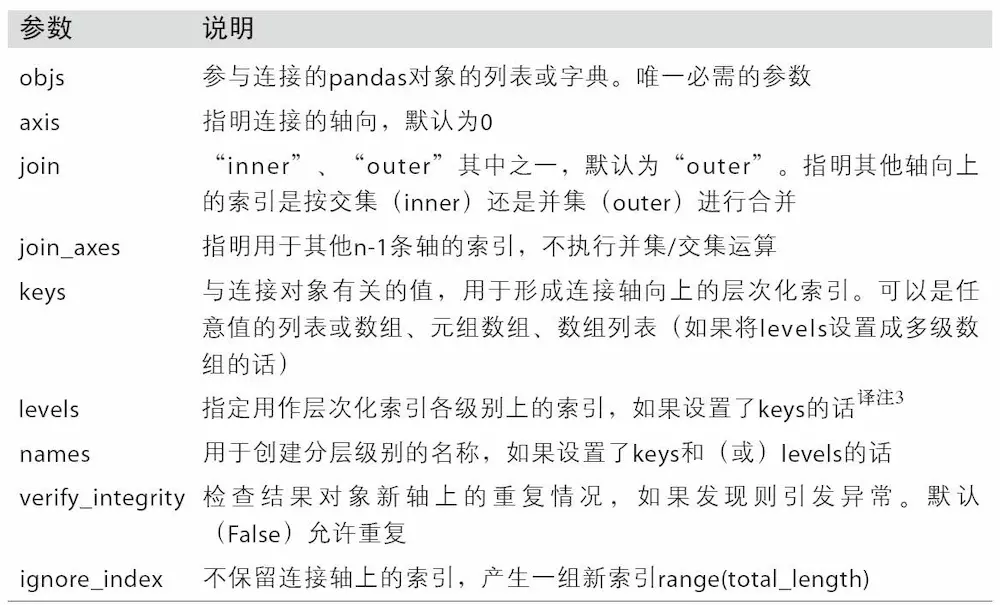

### 合并重叠的数据
+ combine_first（对Series和DataFrame都有作用）

还有一种数据组合问题不能用简单的合并（merge）或连接（concatenation）运算来处理。比如说，你可能有索引全部或部分重叠的两个数据集。举个有启发性的例子，我们使用NumPy的where函数，它可以进行一种等价于面向数组的if-else操作：

In [74]:
a = pd.Series([np.nan, 2.5, 0.0, 3.5, 4.5,np.nan],
             index=list('fedcba'))
a

f    NaN
e    2.5
d    0.0
c    3.5
b    4.5
a    NaN
dtype: float64

In [75]:
b = pd.Series([0., np.nan, 2., np.nan, np.nan, 5.],
             index=list('abcdef'))
b

a    0.0
b    NaN
c    2.0
d    NaN
e    NaN
f    5.0
dtype: float64

Series有一个combine_first方法，实现的也是一样的功能，还带有pandas的数据对齐：

In [76]:
b[:-2].combine_first(a[2:])

a    0.0
b    4.5
c    2.0
d    0.0
dtype: float64

对于DataFrame，combine_first自然也会在每一列上做同样的事情，因此可以将其看做：用传递对象中的数据给调用对象的缺失数据“打补丁”：

In [164]:
df1 = pd.DataFrame({'a':[1,np.nan, 5.,np.nan],
                  'b':[np.nan,2.,np.nan,6.],
                  'c':range(2,18,4)})
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [165]:
df2 = pd.DataFrame({'a':[5.,4.,np.nan,3.,7.],
                   'b':[np.nan,3.,4.,6.,8.]})
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [167]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 重塑与透视（reshaping and pivoting）

有许多用于重新排列表格型数据的基础运算。这些函数也称作重塑（reshape）或轴向旋转（pivot）运算。

### 使用分层索引进行重塑

分层索引为DataFrame数据的重排提供了一种一致性的方式，一下是两个基础操作：
+ stack（堆叠）：将列中的数据透视到行，或者称为“旋转”
+ unstack（拆堆）：将行中数据透视到列

下面将通过一系列的例子来说明这写操作。考虑一个带有字符串数组作为行和列的小型DataFrame：

In [83]:
data = pd.DataFrame(np.arange(6).reshape((2,3)),
                   index=pd.Index(['Ohio','Colorado'],name='state'),
                    columns=pd.Index(['one','tow','three'],name='number'))
data

number,one,tow,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


对该数据使用stack方法即可将列透视到行，得到一个Series：

In [84]:
result = data.stack()
#data.stack(level=-1, dropna=True)
result

state     number
Ohio      one       0
          tow       1
          three     2
Colorado  one       3
          tow       4
          three     5
dtype: int32

对于一个分层索引的Series，你可以用unstack将其重排为一个DataFrame：

In [85]:
result.unstack()
#result.unstack(level=-1, fill_value=None)

number,one,tow,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


默认情况下，unstack是对最内层(偏移量最大)进行操作（stack也是如此）。传入分层级别的编号或名称即可对其它级别进行unstack操作：

In [86]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
tow,1,4
three,2,5


In [87]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
tow,1,4
three,2,5


如果不是所有的级别值都能在各`分组`中找到的话，则unstack操作可能会引入缺失数据：

In [88]:
s1 = pd.Series(np.arange(4),index=list('abcd'))
s1

a    0
b    1
c    2
d    3
dtype: int32

In [89]:
s2 = pd.Series(np.arange(4,7),index=list('cde'))
s2

c    4
d    5
e    6
dtype: int32

In [90]:
data2 = pd.concat([s1,s2],keys=['one','two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int32

In [91]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


stack方法默认会滤除缺失数据，因此该运算是可逆的：

In [92]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [93]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

在对DataFrame进行unstack操作时，作为旋转轴的级别将会成为结果中的最低级别：

In [94]:
df = pd.DataFrame({'left':result,'right':result + 5},
                 columns=pd.Index(['left','right'],name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         tow        1      6
         three      2      7
Colorado one        3      8
         tow        4      9
         three      5     10

In [96]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
tow       1        4     6        9
three     2        5     7       10

**当调用stack，我们可以指明轴向的名字：**

In [203]:
df.unstack('state').stack('state')

side             left  right
number state                
one    Ohio         0      5
       Colorado     3      8
tow    Ohio         1      6
       Colorado     4      9
three  Ohio         2      7
       Colorado     5     10

### 将“长”透视转换为“宽”透视

多个时间序列数据通常是以所谓的“长格式”（long）或“堆叠格式”（stacked）存储在数据库和CSV中的。下面先加载一些示例数据，做一些时间序列规整和数据清洗：

In [103]:
data = pd.read_csv('C:/Users/lenovo/data_of_python/examples/macrodata.csv')
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [104]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter,name='date')
columns = pd.Index(['realgdp','infl', 'unemp'],name='item')
data = data.reindex(columns=columns)
data.index =periods.to_timestamp('D','end')
ldata = data.stack().reset_index().rename(columns={0:'value'})

在第11章中会更深入地讲解PeriodIndex。简单地说，PeriodIndex将year和quarter等列进行联合并生成了一种时间间隔类型：

现在ldata看起来如下：

In [105]:
ldata[:10]

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


这就是多个时间序列或者其它带有两个或多个键的可观察数据（这里，我们的键是date和item）的长格式。表中的每行代表一次观测值。

关系型数据库（如MySQL）中的数据经常都是这样存储的，因为固定架构（即列名和数据类型）有一个好处：随着表中数据的添加，item列中的值的种类能够增加。在前面的例子中，date和item通常就是主键（用关系型数据库的说法），不仅提供了关系完整性，而且提供了更为简单的连接。在有的情况下，使用这种格式的数据会很麻烦，你可能会更喜欢DataFrame，不同的item值分别形成一列，date列中的时间戳则用作索引。DataFrame的pivot方法完全可以实现这个转换：

In [106]:
pivoted = ldata.pivot('date','item','value')
# ldata.pivot(index=None, columns=None, values=None)
pivoted.head(10)

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


前两个传递的参数分别用作行和列索引的name值，最后一个可选参数则是用于填充DataFrame的数据列。假设有两个需要同时重塑的数据列：

In [107]:
ldata['value2'] = np.random.randn(len(ldata))
ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,0.040474
1,1959-03-31,infl,0.000,-0.341778
2,1959-03-31,unemp,5.800,-0.761644
3,1959-06-30,realgdp,2778.801,1.821038
4,1959-06-30,infl,2.340,-0.628320
5,1959-06-30,unemp,5.100,0.728465
6,1959-09-30,realgdp,2775.488,0.402457
7,1959-09-30,infl,2.740,0.970755
8,1959-09-30,unemp,5.300,-0.165429
9,1959-12-31,realgdp,2785.204,-0.812319


如果忽略最后一个参数，得到的DataFrame就会有分层索引的列：

In [108]:
pivoted = ldata.pivot('date','item')
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.341778  0.040474 -0.761644
1959-06-30  2.34  2778.801   5.1 -0.628320  1.821038  0.728465
1959-09-30  2.74  2775.488   5.3  0.970755  0.402457 -0.165429
1959-12-31  0.27  2785.204   5.6 -0.777467 -0.812319 -0.145092
1960-03-31  2.31  2847.699   5.2 -0.501821  0.249111 -1.611380

In [111]:
ldata.pivot('date','item',['value','value2'])[:5]
# 与上面的操作一样，用列表

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.341778  0.040474 -0.761644
1959-06-30  2.34  2778.801   5.1 -0.628320  1.821038  0.728465
1959-09-30  2.74  2775.488   5.3  0.970755  0.402457 -0.165429
1959-12-31  0.27  2785.204   5.6 -0.777467 -0.812319 -0.145092
1960-03-31  2.31  2847.699   5.2 -0.501821  0.249111 -1.611380

In [228]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


注意，**pivot方法等价于set_index创建分层索引**，再用unstack重塑：

In [232]:
ldata.set_index(['date','item'])[:10]

value    value2
date       item                       
1959-03-31 realgdp  2710.349 -0.356272
           infl        0.000  2.338553
           unemp       5.800 -0.583334
1959-06-30 realgdp  2778.801  0.693077
           infl        2.340 -1.302340
           unemp       5.100 -1.466521
1959-09-30 realgdp  2775.488 -0.771889
           infl        2.740  0.204926
           unemp       5.300  1.320715
1959-12-31 realgdp  2785.204 -0.253045

In [234]:
ldata.set_index(['date','item']).unstack()[:10]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  2.338553 -0.356272 -0.583334
1959-06-30  2.34  2778.801   5.1 -1.302340  0.693077 -1.466521
1959-09-30  2.74  2775.488   5.3  0.204926 -0.771889  1.320715
1959-12-31  0.27  2785.204   5.6  0.157688 -0.253045  0.745607
1960-03-31  2.31  2847.699   5.2  1.128214 -0.589364  0.499585
1960-06-30  0.14  2834.390   5.2  2.571054 -0.942861 -0.208625
1960-09-30  2.70  2839.022   5.6 -2.513856 -0.882944 -0.118891
1960-12-31  1.21  2802.616   6.3  0.695480  1.343886  2.416379
1961-03-31 -0.40  2819.264   6.8  2.045094 -0.749065 -1.110220
1961-06-30  1.47  2872.005   7.0  1.332898  0.049748 -1.300908

### 将“宽”透视转化为“‘长”透视

旋转DataFrame的逆运算是pandas.melt。它不是将一列转换到多个新的DataFrame，而是合并多个列成为一个，产生一个比原DataFrame“长”的DataFrame。看一个例子：

In [113]:
df = pd.DataFrame({'key':['foo','var','baz'],
                  'A':[1,2,3],
                  'B':[4,5,6],
                  'C':[7,8,9]})
df

,key,A,B,C
0,foo,1,4,7
1,var,2,5,8
2,baz,3,6,9


key列可能会是分组指标，其它的列是数据值。当使用pandas.melt，我们必须指明哪些列是分组指标。下面使用‘key’作为唯一的分组指标：

In [114]:
melted = pd.melt(df,['key'])
#pd.melt(['frame', 'id_vars=None', 'value_vars=None', 
#         'var_name=None', "value_name='value'", 'col_level=None'])
melted

,key,variable,value
0,foo,A,1
1,var,A,2
2,baz,A,3
3,foo,B,4
4,var,B,5
5,baz,B,6
6,foo,C,7
7,var,C,8
8,baz,C,9


>pd.melt(
    ['frame', 'id_vars=None', 'value_vars=None', 'var_name=None', "value_name='value'", 'col_level=None'],
)

>其中，id_vars表示不变的索引变量；value_vars表示不变的值变量

使用pivot方法，可以将数据重塑会原先的布局：

In [250]:
reshaped = melted.pivot('key','variable','value')
reshaped

variable,A,B,C
key,,,
baz,3,6,9
foo,1,4,7
var,2,5,8


pivot的结果将其中一列创建为一个索引，用作行标签，但是可以使用reset_index将数据移回列：

In [251]:
reshaped.reset_index()

variable,key,A,B,C
0,baz,3,6,9
1,foo,1,4,7
2,var,2,5,8


你还可以指定列的子集，作为值的列：

In [252]:
pd.melt(df,id_vars=['key'],value_vars=['A','B'])

,key,variable,value
0,foo,A,1
1,var,A,2
2,baz,A,3
3,foo,B,4
4,var,B,5
5,baz,B,6


pandas.melt也可以不用分组(索引)指标：

In [253]:
pd.melt(df,value_vars=['A','B','C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9


## 总结

现在你已经掌握了pandas数据导入、清洗、重塑，我们可以进一步学习matplotlib数据可视化。我们在稍后会回到pandas，学习更高级的分析。